# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

## Prerequisites
- Basic Matplotlib skills for plotting 2-D data clearly.
- Basic understanding of Pandas and how to use it for data manipulation.
- The concepts behind clustering algorithms, although we will go through this throughout the project.

## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength / Performance Metric

[**Task 4**](#task4): K-Means Clustering

[**Task 5**](#task5): DBSCAN

[**Task 6**](#task6): HDBSCAN

[**Task 7**](#task7): Addressing Outliers

[**Further Reading**](#further)

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [2]:
df = pd.read_csv('Data/taxi_data.csv')

In [3]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [5]:
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [6]:
df.isna().values.any()

True

In [7]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
Before dropping NaNs and dupes	:	df.shape = (837, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [8]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [14]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

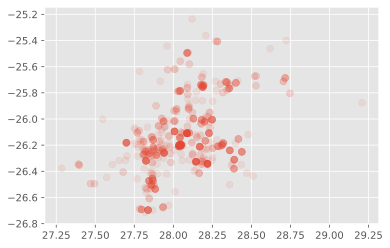

In [23]:
plt.scatter(X[:,0], X[:,1], alpha=0.1, s=50)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [63]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9,
               tiles='Stamen Toner')
# m = folium.Map(location=[4.6486, -74.1125], zoom_start=9,
#                tiles='Stamen Toner')
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),
#         popup='{}'.format(row.NAME),
        color='#1787FE',
        fill=True,
        fill_colour='#1787EF'
    ).add_to(m)

In [64]:
m

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

In [65]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2,
                       cluster_std=0.5, random_state=4)

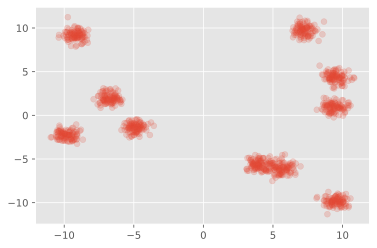

In [66]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

In [67]:
class_predictions = np.load('Data/sample_clusters.npy')

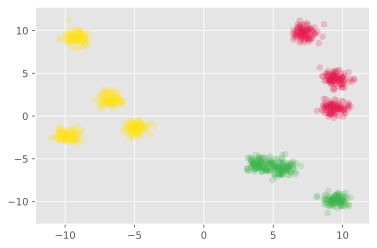

In [69]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [70]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

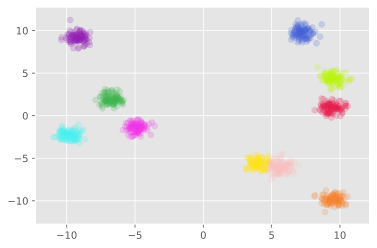

In [71]:
class_predictions = np.load('Data/sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [72]:
class_predictions

array([1, 6, 7, 7, 4, 3, 2, 3, 5, 4, 6, 2, 5, 0, 1, 9, 2, 2, 9, 9, 6, 0,
       7, 8, 1, 9, 5, 3, 8, 2, 1, 2, 0, 7, 8, 5, 7, 2, 9, 8, 8, 5, 7, 5,
       6, 2, 7, 9, 3, 6, 4, 7, 4, 2, 9, 6, 5, 1, 6, 7, 0, 0, 6, 7, 4, 3,
       7, 6, 8, 4, 5, 5, 3, 7, 6, 1, 3, 8, 9, 5, 9, 7, 8, 1, 1, 4, 5, 7,
       4, 7, 7, 8, 1, 2, 5, 7, 2, 3, 6, 6, 7, 8, 4, 8, 2, 6, 8, 8, 7, 1,
       0, 5, 0, 2, 7, 2, 2, 9, 2, 6, 2, 4, 3, 5, 8, 2, 2, 6, 4, 7, 8, 8,
       7, 0, 4, 4, 3, 6, 3, 3, 8, 8, 1, 9, 0, 6, 6, 7, 7, 3, 3, 1, 0, 5,
       2, 3, 0, 8, 0, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 6, 1, 3, 7, 8, 1,
       6, 8, 4, 1, 4, 2, 6, 3, 2, 4, 5, 2, 6, 0, 6, 9, 3, 6, 1, 5, 3, 5,
       4, 5, 7, 6, 4, 5, 5, 4, 5, 5, 7, 0, 2, 1, 7, 9, 2, 6, 6, 0, 1, 0,
       1, 4, 0, 7, 8, 7, 4, 0, 8, 0, 6, 7, 7, 2, 5, 4, 8, 0, 4, 3, 1, 4,
       4, 7, 8, 5, 3, 6, 1, 4, 8, 0, 0, 4, 9, 1, 4, 2, 8, 0, 9, 3, 6, 5,
       4, 0, 6, 2, 3, 0, 1, 2, 5, 9, 8, 0, 7, 1, 7, 0, 9, 0, 4, 0, 7, 9,
       3, 4, 9, 8, 2, 0, 9, 5, 5, 6, 3, 3, 2, 1, 3,

<a id='task4'></a>
# Task 4: K-Means Clustering

In [73]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [80]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [81]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [83]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [84]:
df.head()

,LON,LAT,NAME,CLUSTER_kmeans70
0,28.17858,-25.73882,11th Street Taxi Rank,15
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,15
2,27.83239,-26.53722,Adams Road Taxi Rank,5
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,33
4,28.10144,-26.10567,Alexandra Main Taxi Rank,18


In [87]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        # get a colour
        cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location=[row.LAT, row.LON],
            radius=5,
            popup=row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300948961482


In [88]:
m

In [89]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:32<00:00,  3.06it/s]

K=98
Silhouette Score: 0.6971995093340411


<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [98]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [99]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [103]:
m = create_map(df, 'CLUSTERS_DBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(no_outliers)
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
[   0    0   -4   -5    1    1    1    1    1    1  -12    2    0    0
    0  -17    3    3    3    3    3    3    3    3  -26    0  -28  -29
    4    4    4    4    4    4    4    4    4  -39  -40    0    0    5
  -44  -45  -46  -47    0    6    6    6    6    6    6    0    0    0
    0    7  -60    8    8    8    8    8    8    8    8    8    9    9
    9    9    9    9    9    9    9    9    9    9    9    9    9    9
  -86  -87    9  -89  -90   10   10   10   11   11  -96  -97  -98  -99
    3    3    3    3 -104    0    0 -107 -108 -109   12   12   12   12
   12   12 -116   13   13   13   13 -121 -122 -123 -124 -125 -126   14
   14   15   15   15   15   15 -134   16   16   16   16   16    3    3
 -142 -143 -144 -145 -146 -147 -148   17   17   17   17    9    9    9
   18   18   18   18   18   18   18   18 -164    5   19   19    5   19
   19    5   19   19 -174 -175   20   20

In [101]:
m

<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [ ]:

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

<a id='task7'></a>
# Task 7: Addressing Outliers


In [ ]:

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

<a id='further'></a>
# Further Reading

For some additional reading, feel free to check out [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering respectively.

It may be of use to also check out [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) that are commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.